# Constraints for Tourism Data # 

In our project we have identified the UNWTO Database as the best available source of tourism data. In order to further refine the data for our purposes we need to establish certain constraints within which we will search for results for our solo female traveller. 

- In order to be certain that enough tourist infrastructure exists to ensure her comfort, we wish to establish an appropriate minimum level of tourism. This will be determined by looking at the distribution of tourism across all countries over the course of available data 2018-2022.

- Since cruise ship tourism can give rise to a crowded and inauthentic atmosphere, we wish to establish an appropriate maximum level of cruise tourism. This will be determined by inspecting the distribution of cruise tourism across all countries where data is available, bearing in mind that there do appear to be gaps in this data.

- In order to ensure the safety of our traveller, we will incorporate the UK Foreign Commonwealth & Development Office advice about regions to which we should not travel. Given that the tourism data is only available on a national level, we will use reasonable judgement about which destinations to rule out e.g. follow FCDO advice where a country is ruled out but not where the advice only extends to a very specific location like a volcano within a country, since we can trust our traveller to follow this advice herself without ruling out the whole country.

In [50]:
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [51]:
!pip install thefuzz


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [52]:
import pandas as pd

import numpy as np

from pathlib import Path # For ensuring file maps work across all project members

import matplotlib.pyplot as plt # For plotting boxplots

import seaborn as sns # For appealing boxplots

from thefuzz import process # For fuzzy matching of FCDO restricted travel locations with database locations

In [53]:
data_dir = Path('project_data')

csv_file_path = data_dir / 'tourist_data_cleaned.csv'

df = pd.read_csv(csv_file_path)

In [54]:
df['Country'] = df['Country'].ffill()
df['Country'] = df['Country'].str.title()

In [55]:
# The total arrivals data is sometimes missing, even where at least one of over-night and same-day visitors is present.
# Analysis will be performed on total arrivals, so these missing values must be replaced by the sum of over-night and same-day.
# Then only genuinely missing data will be missing and we will not consider these countries.

# Ensuring NaN values being read properly.

years = ['2018', '2019', '2020', '2021', '2022']
df.loc[:, years] = df[years].apply(pd.to_numeric, errors='coerce')

arrivals_tot = df['Arrivals'] == 'total arrivals'
overnights = df['Arrivals'] == 'overnights visitors (tourists)'
samedays = df['Arrivals'] == 'same-day visitors (excursionists)'

for country in df['Country'].unique(): # Each different country
    country_data = df[df['Country'] == country] # Isolating the rows corresponding to that country

    for year in years:

        total_missing = country_data.loc[arrivals_tot, year].isna()  # Locates NaN total arrivals for country and year
        
        if total_missing.any():

                overnight_value = country_data.loc[overnights, year].values # Had to use .loc to avoid indexing error
                same_day_value = country_data.loc[samedays, year].values
        
                if overnight_value.size > 0: # Using .loc means values returned in an array, so this selects first value in the array.
                    overnight_value = overnight_value[0] # Each should only contain one value as only one row for each country and year.
                else:
                    overnight_value = None
                
                if same_day_value.size > 0:
                    same_day_value = same_day_value[0]
                else:
                    same_day_value = None
        
                if pd.notna(overnight_value) and pd.notna(same_day_value): # Add up available values, only NaN if all NaN
                    total_arrival = overnight_value + same_day_value
                elif pd.notna(overnight_value):  
                    total_arrival = overnight_value
                elif pd.notna(same_day_value):  
                    total_arrival = same_day_value
                else:
                    total_arrival = np.nan
                
                df.loc[(df['Country'] == country) & arrivals_tot & (df[year].isna()), year] = total_arrival # Updates NaN total arrivals for country and year

df.head(50)

# Inspection of e.g. Angola shows that total arrivals is now filled in from available overnights values.

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022
0,0,Albania,,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Albania,arrivals,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Albania,total arrivals,thousands,5927.0,6406.0,2658.0,5689.0,7543.8
3,3,Albania,overnights visitors (tourists),thousands,5340.0,6128.0,2604.0,5515.0,7104.7
4,4,Albania,same-day visitors (excursionists),thousands,587.0,278.0,54.0,174.0,439.1
5,5,Albania,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
6,6,Algeria,,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Algeria,arrivals,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Algeria,total arrivals,thousands,2657.0,2371.0,591.0,125.0,1398.0
9,9,Algeria,overnights visitors (tourists),thousands,NaN,NaN,NaN,NaN,NaN


In [57]:
# Can now narrow down to look at arrivals data. 

arrivals = df['Arrivals'].str.strip()=='total arrivals'
arrivals_df = df[arrivals]

# arrivals_df.info()  to see NaN count

arrivals_df.sample(30)

# Mostly complete, sometimes partial.

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022
656,656,Mali,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN
218,218,Central African Republic,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN
824,824,Palau,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN
140,140,"Bolivia, Plurinational State Of",total arrivals,thousands,NaN,NaN,NaN,NaN,NaN
770,770,New Zealand,total arrivals,thousands,3858.0,3888.0,996.0,207.0,1434.0
776,776,Nicaragua,total arrivals,thousands,1412.0,1455.0,474.0,312.4,932.7
746,746,Namibia,total arrivals,thousands,1639.0,1651.0,187.1,261.3,528.0
1016,1016,State Of Palestine,total arrivals,thousands,3429.0,4232.0,1000.0,NaN,NaN
662,662,Malta,total arrivals,thousands,3232.0,3519.0,718.0,1110.0,2776.2
800,800,North Macedonia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN


In [58]:
# Separately, narrowing down to look at cruise data.

cruise = df['Arrivals'].str.strip() == 'of which, cruise passengers'
cruise_df = df[cruise]

# cruise_df.info() to see NaN count

cruise_df.sample(30)

# Mostly entirely missing, sometimes partial, rarely complete.

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022
791,791,Nigeria,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
845,845,Paraguay,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
191,191,Cabo Verde,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
203,203,Cameroon,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
341,341,Ecuador,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
857,857,Philippines,"of which, cruise passengers",thousands,228.0,162.0,25.0,NaN,NaN
587,587,Lao People´S Democratic Republic,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
227,227,Chad,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN
809,809,Northern Mariana Islands,"of which, cruise passengers",thousands,1.0,3.0,2.0,0.5,0.5
1043,1043,Syrian Arab Republic,"of which, cruise passengers",thousands,NaN,NaN,NaN,NaN,NaN


### Deciding appropriate metrics ###

Using median for cruise tourism as less affected by outliers than the mean, often incomplete, so better for small data set.
Using mean for total arrivals as mostly complete, impact of outliers should be measured as has a greater influence on traveller experience.
Likely that COVID caused big outliers in cruise travel relative to tourism, whereas tourism impact more universal.
Hence again median more appropriate for cruise and mean for arrivals.

Both median and mean in pandas ignore NaN values (not read as 0) and so will return NaN only if all years NaN.

In [59]:
# Finding mean across years for each country.

arrivals_df['Mean Total Arrivals'] = arrivals_df[years].mean(axis=1)

arrivals_df

/var/folders/vs/d_6_sgqj0vj1lc6vqtty67700000gn/T/ipykernel_2309/3892052615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivals_df['Mean Total Arrivals'] = arrivals_df[years].mean(axis=1)


,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals
2,2,Albania,total arrivals,thousands,5927.0,6406.0,2658.0,5689.0,7543.8,5644.76
8,8,Algeria,total arrivals,thousands,2657.0,2371.0,591.0,125.0,1398.0,1428.4
14,14,American Samoa,total arrivals,thousands,51.8,58.6,NaN,NaN,NaN,55.2
20,20,Andorra,total arrivals,thousands,8328.0,8235.0,5207.0,5422.0,8426.7,7123.74
26,26,Angola,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1160,1160,Uzbekistan,total arrivals,thousands,5346.0,6749.0,1504.0,1881.0,5233.0,4142.6
1166,1166,Vanuatu,total arrivals,thousands,350.2,256.0,82.4,NaN,65.0,188.4
1172,1172,Viet Nam,total arrivals,thousands,15498.0,18009.0,3837.0,157.0,3661.0,8232.4
1178,1178,Zambia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
arrivals_df['Mean Total Arrivals'] = pd.to_numeric(arrivals_df['Mean Total Arrivals'], errors='coerce')

arrivals_df['Mean Total Arrivals'].describe()

# From  here we can see that over 198 available countries the Lower Quartile for mean arrivals is 468.7 thousand annual arrivals. 

/var/folders/vs/d_6_sgqj0vj1lc6vqtty67700000gn/T/ipykernel_2309/2347742734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivals_df['Mean Total Arrivals'] = pd.to_numeric(arrivals_df['Mean Total Arrivals'], errors='coerce')


count       137.000000
mean       9898.296918
std       22766.084094
min           2.000000
25%         853.280000
50%        2271.040000
75%        7602.600000
max      172070.250000
Name: Mean Total Arrivals, dtype: float64

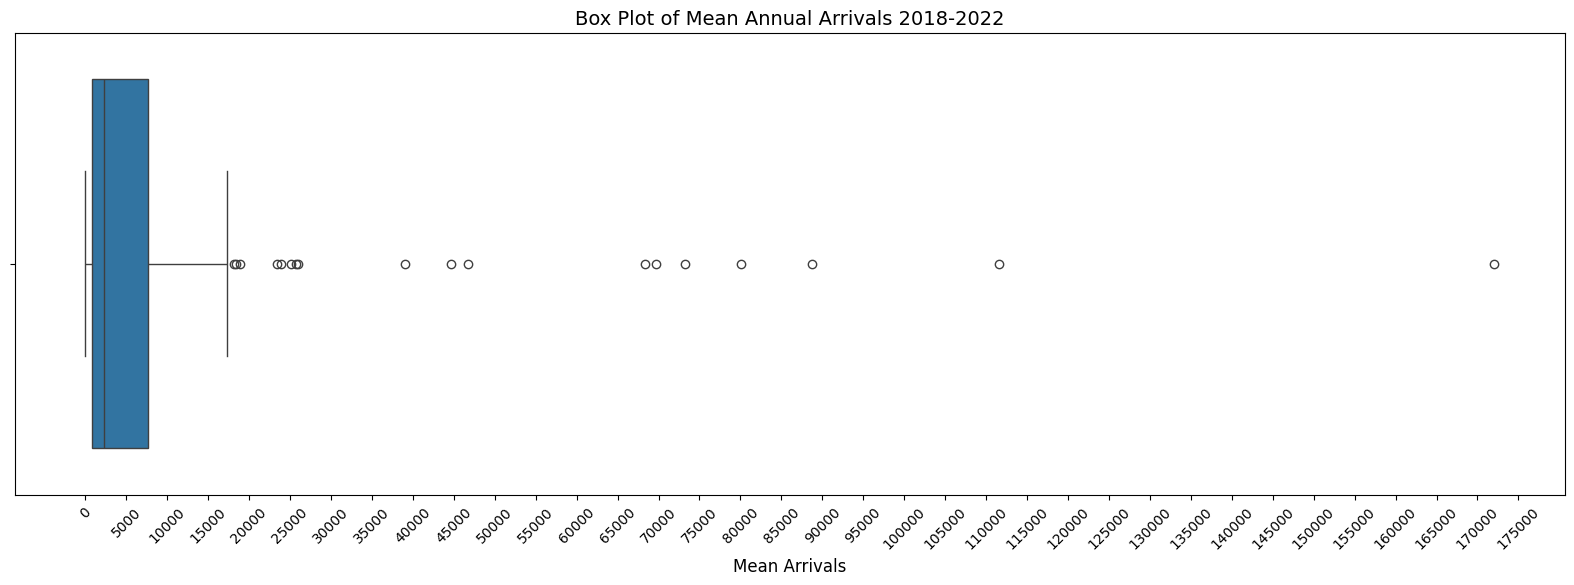

In [61]:
# Creating a boxplot of results

plt.figure(figsize=(20, 6))
sns.boxplot(x=arrivals_df['Mean Total Arrivals'])

plt.title('Box Plot of Mean Annual Arrivals 2018-2022', fontsize=14)
plt.xlabel('Mean Arrivals', fontsize=12)
plt.xticks(np.arange(0, 180000, 5000), rotation=45)

plt.show()

In [62]:
# Box plot demonstrates that there are a lot of extremely high outliers.
# This may be raising the LQ too far and leading us to rule out destinations which do in fact have plenty of tourist infrastructure.

top_75_arrivals = arrivals_df['Mean Total Arrivals'] >= 468.7
arrivals_df[top_75_arrivals].describe()

# We can see 148 countries satisfy are in the top 75% as it stands.

,Unnamed: 0,Mean Total Arrivals
count,114.000000,114.000000
mean,586.315789,11858.071151
std,344.315412,24509.288278
min,2.000000,476.700000
25%,303.500000,1418.850000
50%,551.000000,3224.450000
75%,888.500000,8724.890000
max,1184.000000,172070.250000


In [63]:
# Investigating the option to remove extreme outliers before finding LQ.
# These high outliers are more then 1.5 * IQR above the UQ.

UQ = 8328.8
LQ = 1270.25
IQR = UQ - LQ
up_lim = UQ + 1.5*IQR

# Trimming outliers from the top of the arrivals data:

not_extreme = arrivals_df['Mean Total Arrivals'] < up_lim
arrivals_df[not_extreme].describe()

# LQ is now 357.229167 
# Max now 18902.66 down from 172070.25

,Unnamed: 0,Mean Total Arrivals
count,122.000000,122.000000
mean,589.950820,3588.346954
std,347.669403,4383.125732
min,2.000000,2.000000
25%,297.500000,742.487500
50%,581.000000,1605.112500
75%,894.500000,4939.230000
max,1184.000000,18902.660000


In [64]:
# Which countires are the outliers?

arrivals_df[arrivals_df['Mean Total Arrivals']>= up_lim]

# Though the purpose of the project is to find quieter destinations, it doesn't make sense to remove these busy places at this point.
# Since e.g. Croatia may be still be recommended as quieter than France.
# Restricting the data too far at this point would not be wise, given there are further climate comparisons to be made.

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals
236,236,China,total arrivals,thousands,158606.0,162538.0,27467.0,26380.0,25250.0,80048.2000
284,284,Croatia,total arrivals,thousands,57668.0,60021.0,21608.0,34123.0,50023.0,44688.6000
308,308,Czech Republic (Czechia),total arrivals,thousands,36268.0,37202.0,10267.0,10014.0,NaN,23437.7500
314,314,Denmark,total arrivals,thousands,30801.0,32065.0,16031.0,18372.0,31530.0,25759.8000
386,386,France,total arrivals,thousands,211998.0,217877.0,117109.0,141297.0,NaN,172070.2500
422,422,Greece,total arrivals,thousands,33072.0,34005.0,7406.0,15246.0,29876.0,23921.0000
476,476,"Hong Kong, China",total arrivals,thousands,65148.0,55913.0,3569.0,91.4,604.6,25065.2000
482,482,Hungary,total arrivals,thousands,57667.0,61397.0,31641.0,36688.0,46343.0,46747.2000
524,524,Italy,total arrivals,thousands,93228.6,95399.0,38419.0,40186.0,74317.0,68309.9200
686,686,Mexico,total arrivals,thousands,96497.0,97406.0,51128.0,55301.0,65995.0,73265.4000


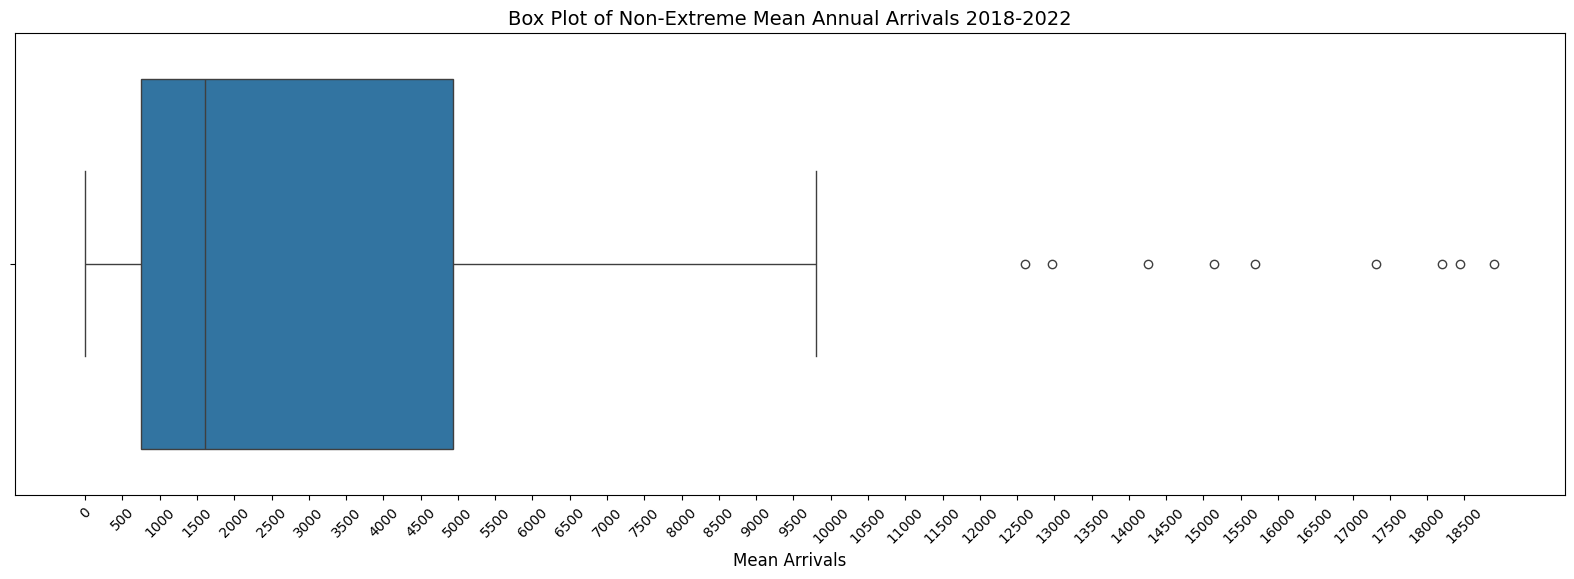

In [65]:
# Creating a boxplot of these results having removed initial outliers:

plt.figure(figsize=(20, 6))
sns.boxplot(x=arrivals_df[not_extreme]['Mean Total Arrivals'])

plt.title('Box Plot of Non-Extreme Mean Annual Arrivals 2018-2022', fontsize=14)
plt.xlabel('Mean Arrivals', fontsize=12)
plt.xticks(np.arange(0, 19000, 500), rotation=45)

plt.show()

In [66]:
top_75_arrivals1 = arrivals_df['Mean Total Arrivals'] >= 357.229167 
arrivals_df[top_75_arrivals1].describe()

# We can see 153 countries are in the top 75%, where outliers have been considered separately.

,Unnamed: 0,Mean Total Arrivals
count,115.000000,115.000000
mean,582.330435,11758.883228
std,345.455807,24424.726528
min,2.000000,451.460000
25%,299.000000,1408.000000
50%,548.000000,3161.100000
75%,887.000000,8711.060000
max,1184.000000,172070.250000


In [67]:
# Checking which countries will be ruled out based on this new LQ value.

arrivals_df[~top_75_arrivals1]

# It seems that some of these countries we may not wish to exclude: Dominica, Frech Polynesia, Madagascar, Seychelles 
# Since these destinations might be places and climates of interest to our traveller, which we know do have sufficient tourist infrastructure.
# Therefore it may be better to choose the lower limit of mean total arrivals to accomodate these, e.g. 190

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals
14,14,American Samoa,total arrivals,thousands,51.8,58.6,NaN,NaN,NaN,55.20
26,26,Angola,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
32,32,Anguilla,total arrivals,thousands,87.0,166.0,41.1,28.7,95.8,83.72
50,50,Armenia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
68,68,Austria,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1094,1094,Tunisia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
1112,1112,Tuvalu,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
1118,1118,Uganda,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
1166,1166,Vanuatu,total arrivals,thousands,350.2,256.0,82.4,NaN,65.0,188.40


In [68]:
top_arrivals = arrivals_df['Mean Total Arrivals'] >= 190
arrivals_df[top_arrivals].describe()

# 167 countries now satisfy this lower limit.

,Unnamed: 0,Mean Total Arrivals
count,126.000000,126.00000
mean,588.190476,10756.13034
std,341.165103,23551.34536
min,2.000000,192.40000
25%,309.500000,1077.37500
50%,560.000000,2621.40000
75%,888.500000,8151.00000
max,1184.000000,172070.25000


In [69]:
# Calculating the %. 

(100*167/198)

# Using 190 thousand mean annual arrivals 2018-2022, we are looking at countries in the top 84.34% for tourism. 

84.34343434343434

In [70]:
# Checking that excluded countries now seem more sensible based on our traveller.

arrivals_df[~top_arrivals]

# This looks better.

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals
14,14,American Samoa,total arrivals,thousands,51.8,58.6,NaN,NaN,NaN,55.20
26,26,Angola,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
32,32,Anguilla,total arrivals,thousands,87.0,166.0,41.1,28.7,95.8,83.72
50,50,Armenia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
68,68,Austria,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1094,1094,Tunisia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
1112,1112,Tuvalu,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
1118,1118,Uganda,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN
1166,1166,Vanuatu,total arrivals,thousands,350.2,256.0,82.4,NaN,65.0,188.40


In [71]:
# All NaN rows in cruise data have been causing run-time issues so going to deal with them first.

all_nan_cruise = cruise_df[years].isna().all(axis=1) 
countries_all_nan_cruise = cruise_df.loc[all_nan_cruise, 'Country'].unique() 

# print("Countries with all NaN for cruise passengers:", countries_all_nan_cruise) # Checking list - long.
# len(countries_all_nan_cruise) 125 in fact.

filtered_cruise = cruise_df.copy()
filtered_cruise = filtered_cruise[~filtered_cruise[years].isna().all(axis=1)] # Drops all nan rows before finding median

In [72]:
filtered_cruise # checking

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022
17,17,American Samoa,"of which, cruise passengers",thousands,31.6,39.4,NaN,NaN,NaN
35,35,Anguilla,"of which, cruise passengers",thousands,3.5,6.1,1.4,NaN,NaN
41,41,Antigua And Barbuda,"of which, cruise passengers",thousands,795.0,734.0,151.0,80.6,377.3
59,59,Aruba,"of which, cruise passengers",thousands,815.0,832.0,255.0,136.0,610.0
83,83,Bahamas,"of which, cruise passengers",thousands,4878.0,5433.0,1327.1,1115.0,5390.0
...,...,...,...,...,...,...,...,...,...
1133,1133,United Arab Emirates,"of which, cruise passengers",thousands,50.0,48.0,40.0,26.0,NaN
1151,1151,United States Virgin Islands,"of which, cruise passengers",thousands,1431.0,1433.0,442.0,245.7,NaN
1157,1157,Uruguay,"of which, cruise passengers",thousands,242.0,260.0,NaN,NaN,NaN
1169,1169,Vanuatu,"of which, cruise passengers",thousands,234.6,135.4,60.4,NaN,35.0


In [73]:
# Finding median of cruise traffic

filtered_cruise['Median Cruise Visitors'] = filtered_cruise[years].median(axis=1)

filtered_cruise

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Median Cruise Visitors
17,17,American Samoa,"of which, cruise passengers",thousands,31.6,39.4,NaN,NaN,NaN,35.5
35,35,Anguilla,"of which, cruise passengers",thousands,3.5,6.1,1.4,NaN,NaN,3.5
41,41,Antigua And Barbuda,"of which, cruise passengers",thousands,795.0,734.0,151.0,80.6,377.3,377.3
59,59,Aruba,"of which, cruise passengers",thousands,815.0,832.0,255.0,136.0,610.0,610.0
83,83,Bahamas,"of which, cruise passengers",thousands,4878.0,5433.0,1327.1,1115.0,5390.0,4878.0
...,...,...,...,...,...,...,...,...,...,...
1133,1133,United Arab Emirates,"of which, cruise passengers",thousands,50.0,48.0,40.0,26.0,NaN,44.0
1151,1151,United States Virgin Islands,"of which, cruise passengers",thousands,1431.0,1433.0,442.0,245.7,NaN,936.5
1157,1157,Uruguay,"of which, cruise passengers",thousands,242.0,260.0,NaN,NaN,NaN,251.0
1169,1169,Vanuatu,"of which, cruise passengers",thousands,234.6,135.4,60.4,NaN,35.0,97.9


In [74]:
filtered_cruise.describe()

# From here we can see the median of cruise traffic is 569 thousand annual cruise visitors, UQ 851 thousand. 

,Unnamed: 0
count,73.000000
mean,586.506849
std,338.070634
min,17.000000
25%,317.000000
50%,569.000000
75%,851.000000
max,1175.000000


### Countries and Regions with ‘Advise Against All Travel’ - UK Foreign Travel Advice ###
As of April 2025, the FCDO advises against all travel to the following countries due to extreme safety risks:
- Afghanistan
- Belarus
- Haiti
- Iran
- Lebanon
- Libya
- Russia
- South Sudan
- Syria
- Yemen
  
and parts of the following countries:

- Algeria: areas within 30km of Algeria’s borders with Libya, Mauritania, Mali, Niger, Tunisia.
- Armenia: areas within 5km of the Armenia-Azerbaijan border.
- Azerbaijan: Nagorno-Karabah, the districts of Zengilan, Jabrayil, Qubadli, Lachin and Kelbajar on the Azerbaijan-Armenia border. The western areas of Khojavand, Fuzuli and Aghdam. Any travel within the 5km border with Armenia.
- Burundi: Cibitoke and Bubanza provinces, Kayanza Province, Melchior Ndadaye International Airport to Cibitoke, Bujumbura Rural Province.
- Benin: Northern border regions, Eastern Benin.
- Burkina Faso: everywhere apart from the capital, Ouagadougou, where it advises against all but essential travel.
- Chad: Borkou, Ennedi Ouest, Ennedi Est and Tibesti provinces, Kanem Province, including Nokou, Lake Chad region, within 30km of all Chad’s other borders. The FCDO advises against all but essential travel to the rest of Chad.
- Côte d’Ivoire: borders with Burkina Faso and Mali, Côte d’Ivoire-Liberia border.
- Cameroon: Bakassi Peninsula, borders with Chad, Central African Republic, Nigeria, the Far-North, North-West, North, South-West and Adamawa regions, Limbé and Maroua.
- Central African Republic: against all travel except to the capital, Bangui.
- Congo: some distrcits in Pool region, border with Central African Republic in Likouala region, Mouyondzi District in Bouenza region.
- Democratic Republic of the Congo: border with Central African Republic, Eastern DRC, areas in the Kinshasa Province, Kwamouth territory of Mai-Ndombe Province, Kasaï Oriental, Kasaï, Kasaï Central.
- Djibouti: border with Eritrea.
- Eritrea: within 25km of Eritrea’s land borders.
- Egypt: border with Libya, North Sinai, northern part of South Sinai, Western Desert, Hala’ib Triangle and Bir Tawil Trapezoid, Eastern part of Ismailiyah Governorate.
- Ethiopia: border areas, Tigray, Amhara, Afar, Gambela, Oromia, Somali, Central, Southern, Sidama, South West and Benishangul-Gumuz regions.
- Georgia: South Ossetia and Abkhazia.
- Indonesia: Mount Lewotobi Laki-Laki, East Nusa Tenggara, Mount Sinabung, North Sumatra, Mount Marapi, West Sumatra, Mount Semeru, East Java, Mount Ruang, Northern Sulawesi, Mount Ibu, North Maluku.
- Iraq: Federal Iraq (see FCDO website for specific areas).
- Israel: Gaza, The West Bank, Northern Israel.
- India: border with Pakistan, Jammu and Kashmir, Manipur.
- Jordan: border with Syria.
- Myanmar: States of Chin, Kachin, Kayah, Kayin, Mon, Rakhine, Shan, regions of North Mandalay and East of the Yangon-Mandalay Expressway in Bago region.
- Mali: advises against all ravel except to Bamako.
- Mauritania: Eastern Mauritania, borders with Mali and Western Sahara, Tiris Zemmour, Adrar, Tagant, Hodh el Gharbi, Assaba, Gorgol and Guidimaka provinces.
- Moldova: Transnistria.
- Mozambique: Cabo Delgado, all but essential travel to the rest of Mozambique.
- Nigeria: areas of North East, North West, South East and South Nigeria.
- Niger: everywhere except Niamey.
- Pakistan: border with Afghanistan, provinces of Khyber Pakhtunkhwa, Balochistan and Sindh, and Pakistan-administered Kashmir.
- The Occupied Palestinian Territories: Gaza, areas near Gaza, the West Bank, Northern Israel.
- Philippines: Mindanao and the Sulu archipelago.
- Saudi Arabia: border with Yemen and Abha International Airport.
- Somalia: Eastern and Western Somaliland.
- Sudan: everywhere apart from Hala’ib Triangle and the Bir Tawil Trapezoid, where all but essential travel is advised.
- Tunisia: Western Tunisia
- Togo: border with Burkina Faso.
- Turkey: border with Syria.
- Ukraine: Crimea, within 50km of Belarus, everywhere else in Ukraine.
- Venezuela: within 80km of the border with Colombia, within 40km of the border with Brazil, Zulia state.
- Western Sahara: areas within 30km north and west of ‘the Berm’ boundary line, and areas in the territory south and east ‘the Berm’ boundary line.

## Conclusions ##

From this analysis we have determined that:

- In searching our data, **tourism** will be measured by the **mean annual arrival of tourists to a country over the period 2018-2022 according to the UNWTO database**. Hence, our 'quieter locations' will be those where this metric is lower.

- Countries with **at least 190 thousand annual arrivals** are in the top 84.34% for tourism, so safe to assume infrastructure exists.

- Countries with **no more than 851 thousand annual cruise tourists** are in the bottom 75% of cruise destinations, so shouldn't be overwhelmed by this kind of tourist traffic.

- Reviewing the FCDO advice, our no travel list at the country level is as follows. Many of these will have been removed from our recommendations due to lack of tourism, but this constraint remains necessary to ensure safety, especially where advice may have changed since 2022.


no_go = [Afghanistan, Belarus, Haiti, Iran, Lebanon, Libya, Russia, South Sudan, Syria, Yemen, Burundi, Burkina Faso, Chad, Cameroon, Central African Republic, Iraq, Israel, Myanmar, Mali, Mozambique, Nigeria, Niger, Palestine, Sudan, Ukraine]


In [75]:
# Coding the list of no travel places 

no_go = ['Afghanistan', 
         'Belarus', 
         'Haiti', 
         'Iran', 
         'Lebanon', 
         'Libya', 
         'Russia', 
         'South Sudan', 
         'Syria', 
         'Yemen', 
         'Burundi', 
         'Burkina Faso', 
         'Chad', 
         'Cameroon', 
         'Central African Republic', 
         'Iraq', 
         'Israel', 
         'Myanmar', 
         'Mali', 
         'Mozambique', 
         'Nigeria', 
         'Niger', 
         'Palestine', 
         'Sudan', 
         'Ukraine']

len(no_go)

25

In [76]:
# Checking that no-go places match 

no_visit = arrivals_df['Country'].isin(no_go)

checked = arrivals_df[no_visit]['Country'].to_list()

updates = [p for p in no_go if p not in checked]

updates # These are the countries whose name from the FCDO did not exactly match one in our data from UNWTO database.

['Afghanistan',
 'Iran',
 'Libya',
 'Russia',
 'South Sudan',
 'Syria',
 'Yemen',
 'Burundi',
 'Iraq',
 'Palestine']

In [77]:
# Searching for like names in arrivals_df

all_countries = arrivals_df['Country'].unique()

for place in updates:
    match, score = process.extractOne(place, all_countries)
    print(f"{place} → {match} (Score: {score})")

Afghanistan → Ghana (Score: 72)
Iran → Iran, Islamic Republic Of (Score: 90)
Libya → Australia (Score: 68)
Russia → Russian Federation (Score: 90)
South Sudan → Sudan (Score: 90)
Syria → Syrian Arab Republic (Score: 90)
Yemen → Sweden (Score: 55)
Burundi → Brunei Darussalam (Score: 69)
Iraq → Iran, Islamic Republic Of (Score: 77)
Palestine → State Of Palestine (Score: 90)


In [78]:
# Updated no_go list to reflect appropriate matches for Iran, Russia, South Sudan, Syria & Palestine.

dont_go = ['Afghanistan', 
         'Belarus', 
         'Haiti', 
         'Iran, Islamic Republic Of', 
         'Lebanon', 
         'Libya', 
         'Russian Federation', 
         'Sudan', 
         'Syrian Arab Republic', 
         'Yemen', 
         'Burundi', 
         'Burkina Faso', 
         'Chad', 
         'Cameroon', 
         'Central African Republic', 
         'Iraq', 
         'Israel', 
         'Myanmar', 
         'Mali', 
         'Mozambique', 
         'Nigeria', 
         'Niger', 
         'State Of Palestine', 
         'Sudan', 
         'Ukraine']

# Remaining places: Yemen, Burundi, Iraq, Afghanistan did not have appropriate tourism data from UNWTO so were not in the original DB.
# Therefore, there is no risk of use sending our traveller to one of these unsafe destinations since they are not included.

In [79]:
# Making a list of countries with too high cruise tourism.
# Easier to make this list and exclude them, since countries with no cruise data were dealt with separately.

filtered_cruise['Median Cruise Visitors'] = pd.to_numeric(filtered_cruise['Median Cruise Visitors'], errors='coerce')
high_cruise = filtered_cruise['Median Cruise Visitors'] > 851
filtered_cruise[high_cruise]

high_cruise_places = filtered_cruise[high_cruise]['Country']

In [80]:
high_cruise_places # Checking 

83                           Bahamas
215                   Cayman Islands
335               Dominican Republic
425                           Greece
473                         Honduras
533                          Jamaica
689                           Mexico
815                           Norway
875                      Puerto Rico
1007                           Spain
1151    United States Virgin Islands
Name: Country, dtype: object

In [81]:
# Making a list of countries above minimal tourism

enough_tourism = arrivals_df['Mean Total Arrivals'] >= 190
arrivals_df[enough_tourism]

enough_tourism_places = arrivals_df[enough_tourism]['Country']

In [82]:
enough_tourism_places # Checking

2                            Albania
8                            Algeria
20                           Andorra
38               Antigua And Barbuda
44                         Argentina
                    ...             
1148    United States Virgin Islands
1154                         Uruguay
1160                      Uzbekistan
1172                        Viet Nam
1184                        Zimbabwe
Name: Country, Length: 126, dtype: object

In [83]:
# Refining data to show only those countries which are safe to travel, with enough overall tourism and not too much cruise tourism.

tourism = arrivals_df['Country'].isin(enough_tourism_places)
cruising = arrivals_df['Country'].isin(high_cruise_places)
no_visit = arrivals_df['Country'].isin(dont_go)

go_to = arrivals_df[tourism & ~cruising & ~no_visit]

In [84]:
go_to # Checking

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals
2,2,Albania,total arrivals,thousands,5927.0,6406.0,2658.0,5689.0,7543.8,5644.7600
8,8,Algeria,total arrivals,thousands,2657.0,2371.0,591.0,125.0,1398.0,1428.4000
20,20,Andorra,total arrivals,thousands,8328.0,8235.0,5207.0,5422.0,8426.7,7123.7400
38,38,Antigua And Barbuda,total arrivals,thousands,1064.0,1035.0,276.0,250.0,642.4,653.4800
44,44,Argentina,total arrivals,thousands,10394.0,11131.0,3096.0,460.0,7503.0,6516.8000
...,...,...,...,...,...,...,...,...,...,...
1142,1142,United States Of America,total arrivals,thousands,169324.918,165478.0,44792.0,66594.0,NaN,111547.2295
1154,1154,Uruguay,total arrivals,thousands,3954.0,3480.0,NaN,234.0,NaN,2556.0000
1160,1160,Uzbekistan,total arrivals,thousands,5346.0,6749.0,1504.0,1881.0,5233.0,4142.6000
1172,1172,Viet Nam,total arrivals,thousands,15498.0,18009.0,3837.0,157.0,3661.0,8232.4000


In [85]:
# Making a list of go-to countries

go_here = go_to['Country'].to_list()
go_here

['Albania',
 'Algeria',
 'Andorra',
 'Antigua And Barbuda',
 'Argentina',
 'Aruba',
 'Australia',
 'Azerbaijan',
 'Bahrain',
 'Barbados',
 'Belize',
 'Benin',
 'Bermuda',
 'Botswana',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cote D´Ivoire',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic (Czechia)',
 'Denmark',
 'Dominica',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Eswatini',
 'Fiji',
 'France',
 'French Polynesia',
 'Georgia',
 'Grenada',
 'Guadeloupe',
 'Guatemala',
 'Hong Kong, China',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Italy',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Kenya',
 'Korea, Republic Of',
 'Kuwait',
 'Kyrgyzstan',
 'Lao People´S Democratic Republic',
 'Latvia',
 'Lesotho',
 'Lithuania',
 'Macao, China',
 'Madagascar',
 'Malaysia',
 'Malta',
 'Martinique',
 'Mauritius',
 'Mongolia',
 'Morocco',
 'Namibia',
 'New Caledonia',
 'New Zealand',
 'Nicaragua',
 'Nor

In [89]:
# To save the recommended info in csv, making a new column.

arrivals_df['Recommendation'] = np.where(arrivals_df['Country'].isin(go_here), 'Go', 'No Go') # Rec is 'go' where in go_here and 'no go' where not

arrivals_df

# data_dir = Path('project_data')

# csv_file_path = data_dir / 'full_sorted_tourism_with_recommendation.csv'

# arrivals_df.to_csv(csv_file_path, index=False)

/var/folders/vs/d_6_sgqj0vj1lc6vqtty67700000gn/T/ipykernel_2309/929478106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrivals_df['Recommendation'] = np.where(arrivals_df['Country'].isin(go_here), 'Go', 'No Go') # Rec is 'go' where in go_here and 'no go' where not


,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals,Recommendation
2,2,Albania,total arrivals,thousands,5927.0,6406.0,2658.0,5689.0,7543.8,5644.76,Go
8,8,Algeria,total arrivals,thousands,2657.0,2371.0,591.0,125.0,1398.0,1428.40,Go
14,14,American Samoa,total arrivals,thousands,51.8,58.6,NaN,NaN,NaN,55.20,No Go
20,20,Andorra,total arrivals,thousands,8328.0,8235.0,5207.0,5422.0,8426.7,7123.74,Go
26,26,Angola,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN,No Go
...,...,...,...,...,...,...,...,...,...,...,...
1160,1160,Uzbekistan,total arrivals,thousands,5346.0,6749.0,1504.0,1881.0,5233.0,4142.60,Go
1166,1166,Vanuatu,total arrivals,thousands,350.2,256.0,82.4,NaN,65.0,188.40,No Go
1172,1172,Viet Nam,total arrivals,thousands,15498.0,18009.0,3837.0,157.0,3661.0,8232.40,Go
1178,1178,Zambia,total arrivals,thousands,NaN,NaN,NaN,NaN,NaN,NaN,No Go


In [88]:
# Highlighting in green those countries to which we will recommend travel.

def highlight_(row):
    color = 'lightgreen' if row['Recommendation'] == 'Go' else 'pink'
    return [f'background-color: {color}'] * len(row)

styled_df = arrivals_df.style.apply(highlight_, axis=1)
styled_df

,Unnamed: 0,Country,Arrivals,Units,2018,2019,2020,2021,2022,Mean Total Arrivals,Recommendation
2,2,Albania,total arrivals,thousands,5927.000000,6406.000000,2658.000000,5689.000000,7543.800000,5644.760000,Go
8,8,Algeria,total arrivals,thousands,2657.000000,2371.000000,591.000000,125.000000,1398.000000,1428.400000,Go
14,14,American Samoa,total arrivals,thousands,51.800000,58.600000,nan,nan,nan,55.200000,No Go
20,20,Andorra,total arrivals,thousands,8328.000000,8235.000000,5207.000000,5422.000000,8426.700000,7123.740000,Go
26,26,Angola,total arrivals,thousands,nan,nan,nan,nan,nan,nan,No Go
32,32,Anguilla,total arrivals,thousands,87.000000,166.000000,41.100000,28.700000,95.800000,83.720000,No Go
38,38,Antigua And Barbuda,total arrivals,thousands,1064.000000,1035.000000,276.000000,250.000000,642.400000,653.480000,Go
44,44,Argentina,total arrivals,thousands,10394.000000,11131.000000,3096.000000,460.000000,7503.000000,6516.800000,Go
50,50,Armenia,total arrivals,thousands,nan,nan,nan,nan,nan,nan,No Go
56,56,Aruba,total arrivals,thousands,1897.000000,1951.000000,623.000000,943.000000,1711.000000,1425.000000,Go
